1) Read in all files
2) See how many 0's, 1's
3) Analyze file (see the average length) 

In [18]:
import os

replay_path = "c:\\data\\label\\"
for dirName, subdirList, fileList in os.walk(replay_path):
    zeros = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '0']
    ones = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '1']
print(f"Zeros: {len(zeros)}\nOnes: {len(ones)}")
    

Zeros: 25
Ones: 25


In [19]:
import pandas as pd

all_files = zeros + ones
file_lengths = []
for f in all_files:
    df = pd.read_csv(os.path.join(replay_path,f))
    file_lengths.append(df.shape[0])
pd.Series(file_lengths).describe()


count     50.00000
mean     583.66000
std      125.65463
min      295.00000
25%      530.50000
50%      633.00000
75%      658.00000
max      776.00000
dtype: float64

4) For each file, take 5 seconds before and 1 second after the event of interest (sampling every 0.5 seconds)

In [20]:
sample_interval = 0.5
seconds_before = 5
seconds_after = 1

all_seqs = []
for file in all_files:
    df = pd.read_csv(os.path.join(replay_path,file),index_col=0)
    min_dist = df['hausdorff_distance'].min()
    min_dist_idx = df['hausdorff_distance'].idxmin()
    start_idx = min_dist_idx - seconds_before * (2*sample_interval/0.05)
    stop_idx = min_dist_idx + seconds_after * (2*sample_interval/0.05)

    indices_to_sample = []
    for x in range(int(start_idx),int(stop_idx+1),int(sample_interval/0.05)): indices_to_sample.append(x)

    columns_of_interest = ['hausdorff_distance','angle',
        'ego_vel_x','ego_vel_y','ego_vel_z','ego_accel_x','ego_accel_y','ego_accel_z','ego_ang_vel_x','ego_ang_vel_y','ego_ang_vel_z',
        'adv_vel_x','adv_vel_y','adv_vel_z','adv_accel_x','adv_accel_y','adv_accel_z','adv_ang_vel_x','adv_ang_vel_y','adv_ang_vel_z']
    rows_of_interest = df.loc[indices_to_sample,columns_of_interest]
    one_seq = []
    for index, rows in rows_of_interest.iterrows():
        for elem in rows:
            one_seq.append(elem)
    one_seq.append(file.split(".csv")[0].split("_",2)[2])
    all_seqs.append(one_seq)

full_df = pd.DataFrame(all_seqs, columns=(columns_of_interest * 13 + ['class']))
full_df.to_csv("c:\\data\\labeled_data.csv",index=None)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 261 entries, hausdorff_distance to class
dtypes: float64(260), object(1)
memory usage: 102.1+ KB


5) Generate Train/Test Files

In [25]:
from sklearn.model_selection import train_test_split
x = full_df.iloc[:,:-1]
y = full_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
train = x_train.assign(Class=y_train)
test = x_test.assign(Class=y_test)
train.to_csv('c:\\data\\train_file.csv',index=None)
test.to_csv('c:\\data\\test_file.csv',index=None)


In [28]:
x_train.head()

,hausdorff_distance,angle,ego_vel_x,ego_vel_y,ego_vel_z,ego_accel_x,ego_accel_y,ego_accel_z,ego_ang_vel_x,ego_ang_vel_y,...,ego_ang_vel_z,adv_vel_x,adv_vel_y,adv_vel_z,adv_accel_x,adv_accel_y,adv_accel_z,adv_ang_vel_x,adv_ang_vel_y,adv_ang_vel_z
22,17.549877,4.169937,-2.580058,0.190064,-0.008083,1.171660,-0.134341,-0.025689,0.265427,0.207384,...,-0.000025,0.150665,3.458804,0.007397,-0.000012,-0.000134,0.000034,-0.000041,0.000005,0.000475
24,8.526672,22.055940,-2.226957,1.315113,0.005590,0.978084,-0.730054,0.007896,0.609201,0.348161,...,-0.000042,0.121638,2.793959,0.005972,0.000319,-0.000072,-0.000033,-0.000132,0.000337,-0.212651
40,27.283388,-3.346074,-2.699470,0.155313,-0.003444,1.203628,-0.128022,-0.058650,0.123642,0.648960,...,-9.711725,1.943199,0.033843,0.008394,3.530073,0.027712,-0.001379,-0.313744,0.545273,-3.095022
26,5.903178,-41.694407,-1.829691,1.896804,0.005960,0.263791,-1.113589,-0.028800,1.520289,-0.788821,...,-0.000206,0.111499,2.559974,0.005472,-0.000346,0.000029,-0.000034,0.000161,-0.000671,0.329844
18,14.589616,59.884899,-2.581676,1.090688,0.002064,-1.706939,0.694611,0.009445,-0.478458,-0.516140,...,-5.959656,0.075091,1.736641,0.004916,-0.002296,-0.003316,-0.001496,-0.058242,-0.076298,-0.663980


In [35]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

RF = RandomForestClassifier()
RF.fit(x_train,y_train)
RF.score(x_test,y_test)

1.0

[(200, 'hausdorff_distance', 0.05252325864556349), (160, 'hausdorff_distance', 0.052157671037962795), (240, 'hausdorff_distance', 0.04639934027909806), (220, 'hausdorff_distance', 0.04611641903367682), (120, 'hausdorff_distance', 0.04562602339181287), (180, 'hausdorff_distance', 0.041787137571488), (80, 'hausdorff_distance', 0.0290145984224892), (241, 'angle', 0.02562027477195864), (0, 'hausdorff_distance', 0.02536379769299024), (101, 'angle', 0.025267006802721093), (124, 'ego_vel_z', 0.02338207181352643), (100, 'hausdorff_distance', 0.020163392857142855), (173, 'adv_vel_z', 0.019357017543859645), (40, 'hausdorff_distance', 0.019192403332520373), (60, 'hausdorff_distance', 0.01731203007518797), (141, 'angle', 0.01687781954887218), (213, 'adv_vel_z', 0.016204251595851486), (20, 'hausdorff_distance', 0.015878299689440992), (161, 'angle', 0.015579719939446367), (221, 'angle', 0.014579463364293086)]


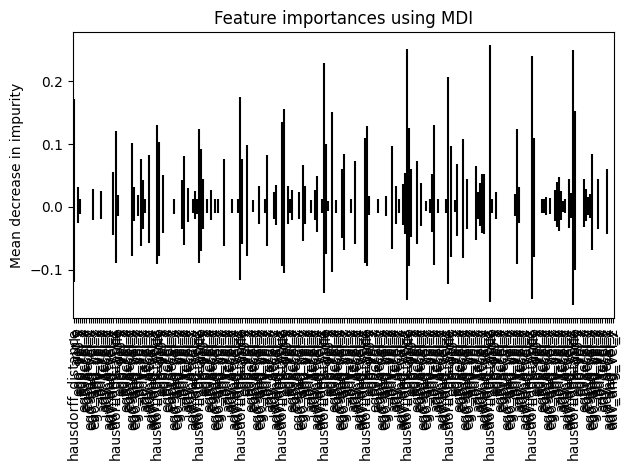

In [62]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
feature_names=x_test.columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)

#print(np.sort(importances)[::-1])
sorted_importances = np.argsort(importances)[::-1][:20]
print([(i,feature_names[i],importances[i]) for i in sorted_importances])


forest_importances.to_csv("forest_importance.csv")

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


